<a href="https://colab.research.google.com/github/idild13/predict-next-fashion/blob/main/notebooks/01_predict_next_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 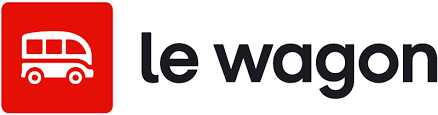

# Predict next fashion

Designing new products for a fashion line takes time. Taking finished products from design to market can have lead times of a year or more! Therefore, the ability to predict upcoming trends in the market has the potential to avoid financial losses and wastage.

With that in mind, let's try using social network signals to anticipate and predict the next big fashion trends!

## Load data

a) Download the [`tendances.csv`](https://drive.google.com/file/d/15xv2daQ03RnTL8fHksHxQFC3yrU7VFVg/view?usp=drive_link) file and import it to Colab.

Let's take a look at the data. The columns represent different types of clothing and the rows represent dates between 2015 and 2019. The values correspond to an internal index related to their popularity on social networks.

We're trying to predict future values for each type of clothing.

Load the data into a `df` DataFrame. Use the parameter `index_col=0` to set the first column as the index.

What is the period? Weekly, monthly, ...?

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tendances.csv to tendances.csv


In [ ]:
import pandas as pd
df = pd.read_csv('tendances.csv', index_col=0)
df # on a weekly basis

,shoes_laceup,body_spaghettistraps,top_tanksleeve_tshirtneck,pants_denim,eyewear_squaredglassesshape
2015-01-05,0.059474,0.001604,0.002377,0.024241,0.002614
2015-01-12,0.071067,0.001621,0.001561,0.023861,0.003187
2015-01-19,0.077554,0.001157,0.001768,0.027625,0.002160
2015-01-26,0.061715,0.001067,0.002447,0.029950,0.002032
2015-02-02,0.060737,0.001118,0.001854,0.030590,0.003329
...,...,...,...,...,...
2018-12-03,0.078668,0.001051,0.000307,0.035552,0.000528
2018-12-10,0.074110,0.001052,0.000000,0.034290,0.000748
2018-12-17,0.070240,0.001269,0.000000,0.034198,0.000460
2018-12-24,0.066915,0.001168,0.000000,0.034580,0.000825


b) Plot all the series on the same chart with `plotly.express`

In [ ]:
import plotly.express as px

px.line(df)

c) Do you notice any clear trends (upwards or downwards) for any of the clothing items?

Indeed, we can see a few major trends appearing:

- lace-up shoes (`shoes_laceup`), denim (`pants_denim`) are on the rise globally

- tanks with close round collars (`top_tanksleeve_tshirtnect`) and square glasses (`eyewear_squaredglassesshape`) are decreasing globally

- dresses or shirts with thin straps (`body_spaghettistraps`) are increasing year after year, but only in summer; they remain stable in the other seasons

d) Can you recognise any instances of seasonality?

For all series, it is clear that the same patterns recur year after year. The data is on a weekly basis and we clearly have cycles of size 52 (hint: there are 52 weeks in a year).

e) There's a quick way to confirm our intuition about the seasonality of these fashion trends. We can decompose time series data to see the `trend` + `seasonality` + `residuals`.

Execute the cell below to see the results for denim trousers.

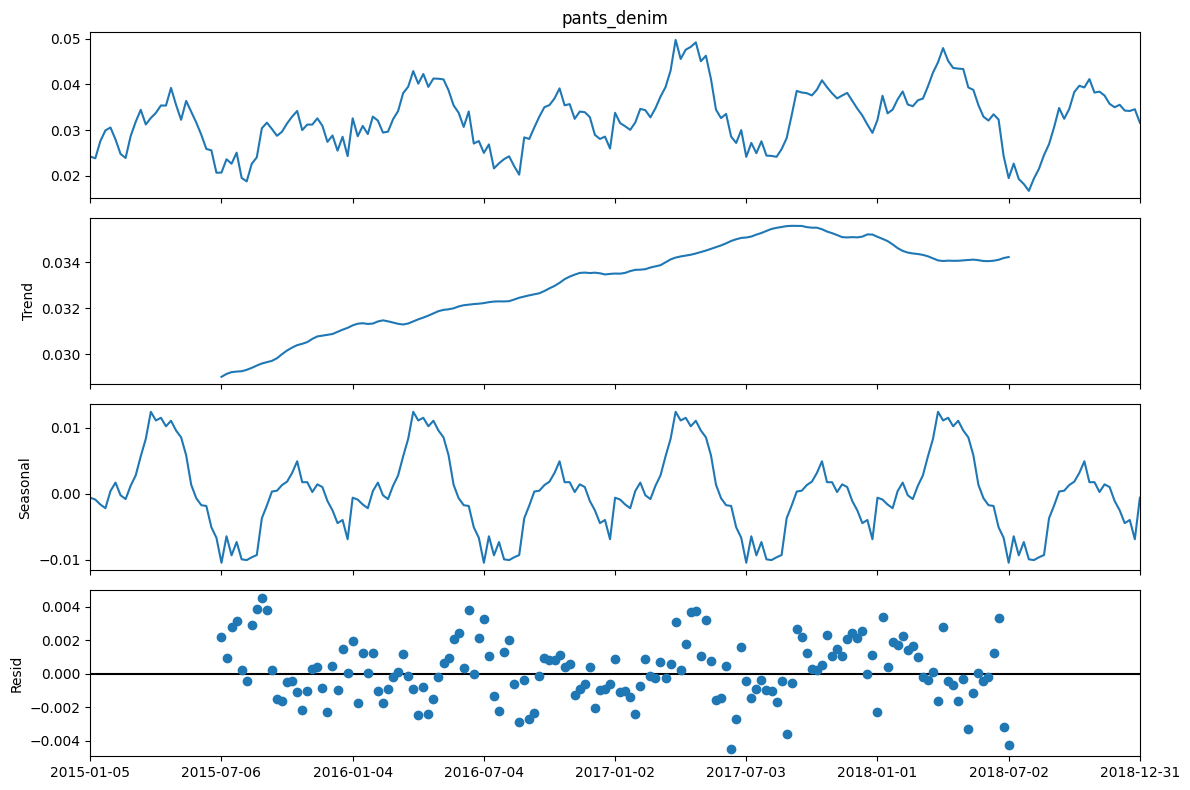

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# decompose time serie
r = seasonal_decompose(df['pants_denim'], period=52)

# save plot to fig variable
fig = r.plot() # Returns a Matplotlib Figure with 4 subplots stacked vertically: 1.	Observed 2.	Trend 3.	Seasonal 4.	Residual

Mathematically:

\text{Observed} = \text{Trend} + \text{Seasonal} + \text{Residual}
	•	In multiplicative decomposition, it’s:
\text{Observed} = \text{Trend} \times \text{Seasonal} \times \text{Residual}

# set custom dimensions
fig.set_figwidth(12)
fig.set_figheight(8)
plt.tight_layout()

# delete all x axis except
for ax in fig.get_axes(): # .get_axes() returns a list of all Axes (subplots) inside the figure.
    ax.set_xticks(list(range(0,209,26)))# 	Creates a list of numbers from 0 to (but not including) 209, stepping by 26: [0, 26, 52, 78, 104, 130, 156, 182, 208]

# why 26? If your data is weekly, then:
	#•	Each tick on the x-axis = 1 week.
	#•	Stepping by 26 means every 26 weeks → about half a year (since 26 weeks ≈ 6 months).
  #•  The date labels in the chart is in a 6-month basis

f) Can you interpret the seasonality of denim trousers using the above results?

- Were there times throughout the year when denim trousers were more popular?

- What do you think you could say about the popularity of denim between 2015 and 2018 given these results?

Try modifying the code in the cell above to view the breakdowns of a few other items of clothing. Before running the code for each item, why not have a go at predicting the trends yourself? Were your fashion intuitions visionary or passé?

- Reading the `Seasonal` line, we can see that people wear denim in two seasons, spring and fall (these are the two recurring "bumps" in seasonality)

- Reading the `Trend` line, we see that the trend is up between 2015 and 2018, then stabilizes

## Preprocessing data



a) To prepare the modelling, we need to make sure that our DataFrame is formatted correctly for a Time Series model. For this we will need:

- an index with a weekly frequency and a periodic type (e.g. `dtype: 'period[W-MON]'`)

- and a time type column named `date` (e.g. `dtype: datetime64[ns]`)

To achieve this, we'll need to do some pre-processing.

Our index is already a date, right? Or is it? Let's investigate!

In [ ]:
df.index.dtype

# dtype('O') = object type

dtype('O')

Looks like we'll need to turn our index into a date type and change the frequency to weekly

<details>
<summary>Hint</summary>

You can't use pd.to_datetime on the index directly, you'll need to:
- create a new column based on the index values
- make that column a datetime
- replace the index with the new values!

For swapping the frequency, let's look at the documentation here: [to_period()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_period.html)

</details>

In [ ]:
# Create a new column 'date' containing the df.index cast into datetime format
df['date'] = pd.to_datetime(df.index)

# set index with date column values
df.index = df['date'].values

# make index periodic
df.index = df.index.to_period()
df

,shoes_laceup,body_spaghettistraps,top_tanksleeve_tshirtneck,pants_denim,eyewear_squaredglassesshape,date
2014-12-30/2015-01-05,0.059474,0.001604,0.002377,0.024241,0.002614,2015-01-05
2015-01-06/2015-01-12,0.071067,0.001621,0.001561,0.023861,0.003187,2015-01-12
2015-01-13/2015-01-19,0.077554,0.001157,0.001768,0.027625,0.002160,2015-01-19
2015-01-20/2015-01-26,0.061715,0.001067,0.002447,0.029950,0.002032,2015-01-26
2015-01-27/2015-02-02,0.060737,0.001118,0.001854,0.030590,0.003329,2015-02-02
...,...,...,...,...,...,...
2018-11-27/2018-12-03,0.078668,0.001051,0.000307,0.035552,0.000528,2018-12-03
2018-12-04/2018-12-10,0.074110,0.001052,0.000000,0.034290,0.000748,2018-12-10
2018-12-11/2018-12-17,0.070240,0.001269,0.000000,0.034198,0.000460,2018-12-17
2018-12-18/2018-12-24,0.066915,0.001168,0.000000,0.034580,0.000825,2018-12-24


In [ ]:
df.drop(columns=['date'], inplace=True)

b) Now we'll need to split the train and test data. We will use the last year of data as our test set (`df_test`) and the rest for training (`df_train`).

We're going to use the `temporal_train_test_split` method. What should you put in the `test_size` parameter?

In [ ]:
!pip install sktime dask[dataframe] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

# 52 weeks = 1 year
df_train, df_test = temporal_train_test_split(df, test_size=52)

print("Train length:", df_train.shape)
print("Test length:", df_test.shape)

Train length: (157, 5)
Test length: (52, 5)


## Modeling

### Modeling - Naive

For simplicity, we will restrict ourselves in this section to the time serie `top_tanksleeve_tshirtneck`.

a) Train a naive model by using `NaiveForecaster` of sktime library.

Predict last year values and store results in a `naive_preds` variable.

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

cloth = 'top_tanksleeve_tshirtneck'

# intialize model with a `sp` parameter
naive_model = NaiveForecaster(sp=52)
# fit model
naive_model.fit(df_train[cloth])
# predict last year values, use list(range(1,53)) to create a list [1,2,...,52]
naive_preds = naive_model.predict(fh=list(range(1,53)))

b) In `df_test` variable, create a new column `naive_model` with naive predictions values.

Visualize predicted and real data with plotly express (y parameter of px.line() function can be a list of columns names)

In [ ]:
# create a new column "naive_model" with naive predictions
df_test["naive_model"] = naive_preds

# visualize data
fig = px.line(df_test, y=[cloth, "naive_model"])
fig.show()

/tmp/ipython-input-2186550285.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



c) Calculate MASE.

How do you interpret this metric? Does the result make sense?

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

naive_MASE = mean_absolute_scaled_error(y_true = df_test[cloth],
                                        y_train = df_train[cloth],
                                        y_pred = df_test["naive_model"])

print(f"{naive_MASE=}")

naive_MASE=np.float64(1.0307477252766177)


<details>
    <summary><i>Response</i></summary>
MASE or Mean Absolute Scaled Error is the mean absolute error of the forecasted values divided by the mean absolute error if we had forecasted using a naive model (read: if we had just taken the same values as the previous season). Here we forecasted using a naive model, so we expected a value close to 1 anyway.
</details>



d) Calculate MAE and SMAPE for the naive model.

Interpret results.

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error

naive_MAE = mean_absolute_error(y_true = df_test[cloth],
                                y_pred = naive_preds)

naive_SMAPE = mean_absolute_percentage_error(y_true = df_test[cloth],
                                             y_pred = naive_preds,
                                             symmetric=True)

print(f"{naive_MAE=}")
print(f"{naive_SMAPE=}")

naive_MAE=np.float64(0.0004627819396491115)
naive_SMAPE=np.float64(0.4984216238514322)


<details>
    <summary><i>Response</i></summary>
The Mean Absolute Error is about 0.0005. Since the time series oscillates globally between 0 and 0.005, the error is not bad: it is at 10% of the usual amplitude of this time series.

SMAPE, on the other hand, is at almost 50% error. This seems to be too much compared to our intuitive perception of the graph, and given the MAE.

The reason is this: SMAPE or Symmetric Mean Absolute Percentage Error, compares for each idividual point in time the error to the average of the true value and the forecast value (and then averages those over all the points in time). Our time series has very low values, especially at the beginning and end of the year. So, if, like around February, for a true value of 0.0005, we predict 0.0010, in absolute terms this a small error, but in relative terms it is far off. And this is what SMAPE calculates: the error (0.0005) divided by the average of true and forecast value (0.00075) which gives 67% for this point!
</details>

### Modeling - Holt-Winters

So, it's time to move on from our naive model to a more advanced model. Let's try the Holt-Winters model.
In this model, we start from a base level (the last value of our train data, before we start forecasting), and complete it with a trend component and a seasonal component.

e) Look closely at seasonality and trend, and determine how you want to model:

- the trend, which can be additive (`trend='add'`) or multipliticative (`trend='mul'`)

- the seasonality, which can also be additive (`seasonal='add'`) or multipliticative (`seasonal='mul'`)

Justify your choice.

<details>
    <summary><i>Response</i></summary>

We choose a multiplicative trend, because we are getting closer to 0: an additive model could drive the trend below this threshold! (If starting from a low base level, we each time subtract the same amount, we'll end up below 0. If we multiply the low base level with the same value (less than 1), we'll get closer and closer to 0, but not below 0.)

We choose an additive seasonality, because the maximum amplitude between summer and winter seems fixed year after year.

So we have: `trend='mul'` and `seasonal='add'
</details>

f) Apply a Holt-Winters model on this time series with trend and seasonal options.

Display the predictions.

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

exp_smoothing = ExponentialSmoothing(trend="mul", seasonal="add")
exp_smoothing.fit(df_train[cloth])
exp_smoothing_preds = exp_smoothing.predict(fh=list(range(1,53)))

In [ ]:
# create a new column "holt_winters" with holt_winters predictions
df_test["holt_winters"] = exp_smoothing_preds

# visualize data
fig = px.line(df_test, x="date", y=[cloth, "holt_winters"])
fig.show()

<ipython-input-31-9e52927d609b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



g) Calculate error metrics for this new model (MAE, MASE and SMAPE) as you did questions c) and d).

Do you get a better performance? Interpret results.

In [ ]:
exp_smoothing_MAE = mean_absolute_error(y_true = df_test[cloth],
                                        y_pred = exp_smoothing_preds)

exp_smoothing_SMAPE = mean_absolute_percentage_error(y_true = df_test[cloth],
                                                     y_pred = exp_smoothing_preds,
                                                     symmetric=True)

exp_smoothing_MASE = mean_absolute_scaled_error(y_true = df_test[cloth],
                                                y_pred = exp_smoothing_preds,
                                                y_train = df_train[cloth])

print(f"{exp_smoothing_MAE=}")
print(f"{exp_smoothing_SMAPE=}")
print(f"{exp_smoothing_MASE=}")

exp_smoothing_MAE=0.0003048290581293239
exp_smoothing_SMAPE=0.3900722390547852
exp_smoothing_MASE=0.6789414870062717


Predictions are very close to reality. We also observe an improvement according to all our metrics: this model is indeed an improvement compared to the naive model.

The MASE allows us to quantify specifically the improvement compared to the naive model: with a value of `0.68`, we can verify that our Holt-Winters model is 1/3 better than a naive model.